In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from gensim.models import Word2Vec


2023-05-02 10:55:12.650998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-02 10:55:12.651016: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [70]:

# Load your dataset
df = pd.read_csv("final_data.csv")
from sklearn.preprocessing import LabelEncoder


# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the "Output" column and transform it
df["Output"] = label_encoder.fit_transform(df["Output"])

# Preprocess the data by combining the Resume_Text and Job_Description columns
df["combined_text"] = df["Resume_Text"] + " " + df["Job_Description"]


In [71]:
df["combined_text"].isnull().sum()

0

In [72]:
df['Output'].value_counts()

1    10481
0     9362
Name: Output, dtype: int64

In [73]:
df

,Unnamed: 0,Resume_Text,Job_Description,similarity,similarity2,Output,combined_text
0,0,sr python developer sr python developer sr pyt...,ssssjob title senior python developer job desc...,0.713416,0.928744,0,sr python developer sr python developer sr pyt...
1,1,full stack developer full stack developer full...,job title full stack developer location housto...,0.767558,0.977133,0,full stack developer full stack developer full...
2,2,accountant summary financial accountant specia...,firewall architectlocation atlantaga 30339 dur...,0.040615,0.327215,1,accountant summary financial accountant specia...
3,3,bilingual pretrial supervisor bilingual pretri...,ssjob title bilingual pretrial supervisor loca...,0.783257,0.972054,0,bilingual pretrial supervisor bilingual pretri...
4,4,database administrator database administrator ...,ssjob title database administrator location ch...,0.728063,0.935685,0,database administrator database administrator ...
...,...,...,...,...,...,...,...
19838,19838,technical support engineer technical support e...,sssjob title technical support engineer locati...,0.703768,0.898069,0,technical support engineer technical support e...
19839,19839,system administrator system administrator gard...,ssssjob title senior system administrator loca...,0.714000,0.913010,0,system administrator system administrator gard...
19840,19840,freelance website designer summary marine corp...,net integration developer longterm contract mt...,0.105613,0.500174,1,freelance website designer summary marine corp...
19841,19841,director finance professional summary progress...,senior javascript developer learn mean stack e...,0.060547,0.177197,1,director finance professional summary progress...


In [74]:
df["combined_text"] = df["combined_text"].fillna('').astype(str)


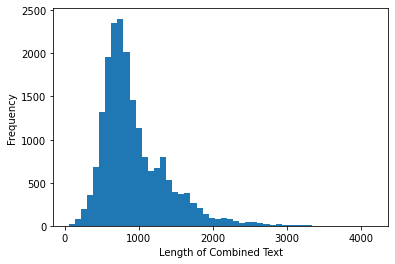

In [75]:
import matplotlib.pyplot as plt

lengths = [len(text.split()) for text in df["combined_text"]]
plt.hist(lengths, bins=50)
plt.xlabel("Length of Combined Text")
plt.ylabel("Frequency")
plt.show()


In [76]:
# Tokenize and pad the text data
max_len = int(np.percentile(lengths, 95))  # 95th percentile
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["combined_text"])
sequences = tokenizer.texts_to_sequences(df["combined_text"])
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=max_len)



In [77]:
# Load your trained word2vec model
word2vec = Word2Vec.load("Lastword2vec.model")


In [78]:
embedding_dim = 100  # Update this to match the vector_size you used in your word2vec model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]


In [96]:

# Create the LSTM model
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(64))
#model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [97]:

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, df["Output"], test_size=0.2, random_state=42)



In [98]:
# Train the model with early stopping
batch_size = 64
epochs = 1
early_stopping = EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)
checkpoint = ModelCheckpoint("LASTLSTMmodel2.h5", save_best_only=True, monitor="val_loss", mode="min")



In [99]:
import torch

torch.cuda.empty_cache()

In [100]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [101]:
torch.cuda.empty_cache()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, checkpoint])


249/249 [==============================] - 239s 953ms/step - loss: 0.2263 - accuracy: 0.9165 - val_loss: 0.1126 - val_accuracy: 0.9640


In [103]:
import numpy as np
import keras
from sklearn.metrics import classification_report

# Load the saved model from H5 file
#model = keras.models.load_model('LASTLSTMmodel.h5')


# Use the model to predict labels for test data
y_pred = model.predict(X_val)
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Print classification report
target_names = ['MATCH',"NOT MATCH"] # List of class names
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       MATCH       0.96      0.97      0.96      1915
   NOT MATCH       0.97      0.96      0.97      2054

    accuracy                           0.96      3969
   macro avg       0.96      0.96      0.96      3969
weighted avg       0.96      0.96      0.96      3969

